In [66]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## Define constans and functions

In [67]:
locations = ["A", "B", "C"]
scaler = None
features_order = []

LAGGED_COLUMNS_TO_KEEP = [
    "pv_measurement_prev_month",
    "pv_measurement_prev_year",
    "pv_measurement_2years_ago",
]

CUSTOM_COLUMNS_TO_KEEP = [
    "hour_cos",
    "hour_sin",
    "month_sin",
    "month_cos",
    "day-of-year",
]

COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
     "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    # "date_calc",
    "pv_measurement",
] + CUSTOM_COLUMNS_TO_KEEP

TEST_COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
     "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    # "date_calc",
    # "pv_measurement",
] + CUSTOM_COLUMNS_TO_KEEP + LAGGED_COLUMNS_TO_KEEP

def create_weather_lagged_features(df, weather_features):
    # Choose the weather features for which you want to create lagged versions
    for feature in weather_features:
        # Assuming hourly data, adjust the lags for your specific dataset
        # Creating lagged features for 1 hour, 1 day, and 1 week
        df[f'{feature}_lag_1h'] = df[feature].shift(4)
        df[f'{feature}_lag_24h'] = df[feature].shift(24*4)
        df[f'{feature}_lag_168h'] = df[feature].shift(24 * 7 * 4 * 365)
        df[f'{feature}_front_lag_1h'] = df[feature].shift(-4)
        df[f'{feature}_front_lag_24h'] = df[feature].shift(-24*4)


    # Handling edges by filling NaNs with appropriate values or dropping them
    # You may choose to fill with zeroes or interpolate, based on what makes more sense for your data
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill
    
    return df


def create_lagged_features(df, column_name='pv_measurement'):
    # Assuming 'date_forecast' is the datetime column used for sorting

    df[f'{column_name}_prev_month'] = df[column_name].shift(24*7) # previous week

    # For yearly lag, you would need to calculate the number of observations per year
    # If the data is not consistent (leap years, etc.), you may need a more complex method
    # Here's a simple version assuming 365 days a year:
    df[f'{column_name}_prev_year'] = df[column_name].shift(24*365) # previous year
    df[f'{column_name}_2years_ago'] = df[column_name].shift(24*365*2) # next year

    # Handling edges by filling NaNs with appropriate values or dropping them
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill

    return df


## Clean data 

In [68]:
def generate_and_save_engineered_features(estimated_parquet_file=None, output_parquet_file="engineered_data.parquet"):
    # Load main dataset, observed dataset, and target dataset
    df_merged= pd.read_parquet(estimated_parquet_file)

    print(df_merged.head())


    # Feature Engineering
    df_merged = feature_engineering(df_merged)

    # Save the engineered data
    df_merged.to_parquet(output_parquet_file)
    print(f"Engineered data saved to {output_parquet_file}")


def feature_engineering(df_merged):
    
    # 1. Time-based Features
    # df_merged['hour'] = df_merged['date_forecast'].dt.hour
    # df_merged['month'] = df_merged['date_forecast'].dt.month
    # df_merged['weekday'] = df_merged['date_forecast'].dt.weekday

    # Sinusoidal transformations for cyclical time features
    # df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['hour'] / 24)
    # df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['hour'] / 24)
    # df_merged['month_sin'] = np.sin(2 * np.pi * df_merged['month'] / 12)
    # df_merged['month_cos'] = np.cos(2 * np.pi * df_merged['month'] / 12)
    # df_merged['weekday_sin'] = np.sin(2 * np.pi * df_merged['weekday'] / 7)
    # df_merged['weekday_cos'] = np.cos(2 * np.pi * df_merged['weekday'] / 7)

    # Binning
    # bins = [-90, 0, 45, 90]
    # labels = ['1', '2', '3']
    # df_merged['sun_elevation_binned'] = pd.cut(df_merged['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)


    return df_merged

for location in locations:
    estimated_parquet_file_test = f"data/{location}/X_test_estimated.parquet"
    output_file_test = f"cleaned_data/{location}/X_test_engineered.parquet"
    generate_and_save_engineered_features(estimated_parquet_file=estimated_parquet_file_test, output_parquet_file=output_file_test)
    estimated_parquet_file = f"data/{location}/X_train_estimated.parquet"
    observed_parquet_file = f"data/{location}/X_train_observed.parquet"
    target_parquet_file = f"data/{location}/train_targets.parquet"
    output_file = f"cleaned_data/{location}/X_train_engineered.parquet"
    generate_and_save_engineered_features(estimated_parquet_file=estimated_parquet_file, output_parquet_file=output_file)


            date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2023-04-30 07:00:04 2023-05-01 00:00:00                       4.4   
1 2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2 2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3 2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4 2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.286            912.700012                    0.0   
1                1.287            912.700012                    0.0   
2                1.287            912.700012                    0.0   
3                1.287            912.700012                    0.0   
4                1.287                   NaN                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1041.199951              0.0      271.70001

## Prepare data


In [69]:
def add_custom_fields(df):
     df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
     df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

     df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['day-of-year'] = df['date_forecast'].dt.dayofyear
     return df


In [70]:
def prepare_data(location):
    # Load data
    scaling = True
    global features_order
    # df_combined = pd.read_parquet(f"cleaned_data/{location}/X_train_engineered.parquet")
    df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")

    # 2. Combine observed and estimated datasets
    df_combined = pd.concat([df_observed, df_estimated], axis=0).sort_values(
        by="date_forecast"
    )
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    df_combined = add_custom_fields(df_combined)

    df_combined.set_index('date_forecast', inplace=True)
    df_merged = df_combined.resample('1H').mean()
    # Merge with target data
    df_merged = pd.merge(
        df_merged, df_target, left_on="date_forecast", right_on="time", how="inner"
    )
    # Resample to 1-hour intervals
    # Keep only the columns used during training
    
    df_merged = df_merged[COLUMNS_TO_KEEP]

    df_merged = create_lagged_features(df_merged)
     
    # Remove the pv_measurement feature before splitting into X and y
    y = df_merged["pv_measurement"]
    X = df_merged.drop("pv_measurement", axis=1)
    features_order = list(X.columns)
    print(features_order)
    df_merged.fillna(0, inplace=True)  # Fill NaN values
     # Apply Min-Max normalization to the features
    if scaling: 
        global scaler
        scaler = MinMaxScaler()
        X_normalized = scaler.fit_transform(X)
        # y = np.log1p(df_merged["pv_measurement"])
        return pd.DataFrame(X_normalized, columns=X.columns), y
    else: 
        return X, y

## Train

In [71]:
def train_model(X_train, y_train, location):
    # Use a smaller depth and add more regularization
    model = CatBoostRegressor(
        iterations=6000, # Consider reducing this if you have early stopping
        learning_rate=0.005,
        depth=12, # Reduced from 12 to 6
        loss_function='MAE',
        l2_leaf_reg=4, # Increase if needed
        verbose=200,
        # bootstrap_type='Bayesian',  # Change bootstrap type
        # random_strength=3,  # Default is 1, increase to make model more robust
        # bagging_temperature=2,  # Only for Bayesian bootstrap type
    )
    # cat_features = ['sun_elevation_binned']
    # Use a validation set to monitor for early stopping
    X_tr, X_validation, y_tr, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    model.fit(X_tr, y_tr, eval_set=(X_validation, y_validation))
    model.save_model(f"catboost_model_{location}.cbm")

def evaluate_model(X_val, y_val, location):
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_{location}.cbm")
    y_pred = model.predict(X_val)
    # y_val = np.expm1(y_val)
    # y_pred = np.expm1(y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    print(f'Location {location}, Mean Absolute Error: {mae}')


for location in locations:
        # Prepare the training data
        X, y = prepare_data(location)
        
        # Ensure consistent feature ordering
        features_order = list(X.columns)  # Save the feature order after preparation
        
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train the model
        train_model(X_train, y_train, location)
        
        # Evaluate the model
        evaluate_model(X_val, y_val, location)

['direct_rad:W', 'clear_sky_rad:W', 'diffuse_rad:W', 'direct_rad_1h:J', 'is_in_shadow:idx', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'is_day:idx', 'sun_elevation:d', 'ceiling_height_agl:m', 'effective_cloud_cover:p', 'visibility:m', 'total_cloud_cover:p', 'air_density_2m:kgm3', 'wind_speed_v_10m:ms', 'dew_point_2m:K', 'wind_speed_u_10m:ms', 't_1000hPa:K', 'absolute_humidity_2m:gm3', 'snow_water:kgm2', 'relative_humidity_1000hPa:p', 'fresh_snow_24h:cm', 'cloud_base_agl:m', 'fresh_snow_12h:cm', 'snow_depth:cm', 'dew_or_rime:idx', 'fresh_snow_6h:cm', 'super_cooled_liquid_water:kgm2', 'fresh_snow_3h:cm', 'rain_water:kgm2', 'precip_type_5min:idx', 'precip_5min:mm', 'fresh_snow_1h:cm', 'sun_azimuth:d', 'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa', 'prob_rime:p', 'wind_speed_10m:ms', 'elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'snow_melt_10min:mm', 'wind_speed_w_1000hPa:ms', 'hour_cos', 'hour_sin', 'month_sin', 'month_cos', 'day-of-year', 'pv_m

## Make predictions

In [72]:
def make_predictions(df_test, location, target):
    global features_order
    scaling = True
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_{location}.cbm")
    df_test = add_custom_fields(df_test)
    
    df_test.set_index('date_forecast', inplace=True)
    df_test = df_test.resample('1H').mean()
    df_test = pd.merge(
        df_test, target, left_on="date_forecast", right_on="time", how="inner"
    )
    df_test = create_lagged_features(df_test)
    df_test = df_test.dropna(how='all').reset_index(drop=True)
    df_test = df_test[TEST_COLUMNS_TO_KEEP]
    print(df_test.head())

    # Ensure the index is a datetime
    # print(df_test.head())
    
    # Forward fill to handle NaNs

    # Apply the same Min-Max normalization to the test data
    if scaling:
        global scaler
        if scaler is None:
            raise ValueError("Scaler has not been fitted. Run prepare_data first.")
        df_test_normalized = scaler.transform(df_test)
        df_test_normalized = pd.DataFrame(df_test_normalized, columns=df_test.columns)
        # Ensure no datetime columns are left before predicting
        datetime_columns = df_test_normalized.select_dtypes(include=['datetime']).columns
        if len(datetime_columns) > 0:
            raise ValueError(f"Dataframe still contains datetime columns: {datetime_columns}")
        
        # Predict
        preds = model.predict(df_test_normalized)
        
        # Reverse the log transformation for the predictions
        # preds = np.expm1(preds_log)
    else:
        datetime_columns = df_test.select_dtypes(include=['datetime']).columns
        
        # if len(datetime_columns) > 0:
        #     raise ValueError(f"Dataframe still contains datetime columns: {datetime_columns}")
        preds = model.predict(df_test)
    return preds



## Evaluate locally


   direct_rad:W  clear_sky_rad:W  diffuse_rad:W  direct_rad_1h:J  \
0           0.0              0.0            0.0              0.0   
1           0.0              0.0            0.0              0.0   
2           0.0              0.0            0.0              0.0   
3           0.0              0.0            0.0              0.0   
4           0.0              0.0            0.0              0.0   

   is_in_shadow:idx  clear_sky_energy_1h:J  diffuse_rad_1h:J  is_day:idx  \
0               1.0                    0.0               0.0         0.0   
1               1.0                    0.0               0.0         0.0   
2               1.0                    0.0               0.0         0.0   
3               1.0                    0.0               0.0         0.0   
4               1.0                    0.0               0.0         0.0   

   sun_elevation:d  ceiling_height_agl:m  ...  snow_melt_10min:mm  \
0       -39.065250           2416.250000  ...                 0.0

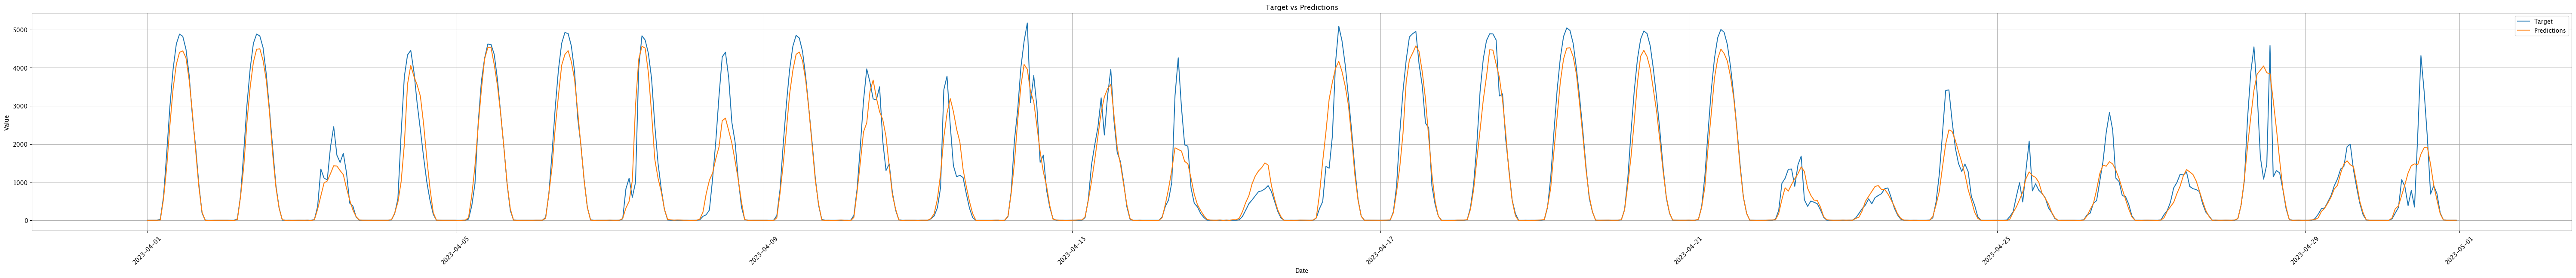

   direct_rad:W  clear_sky_rad:W  diffuse_rad:W  direct_rad_1h:J  \
0           0.0              0.0            0.0              0.0   
1           0.0              0.0            0.0              0.0   
2           0.0              0.0            0.0              0.0   
3           0.0              0.0            0.0              0.0   
4           0.0              0.0            0.0              0.0   

   is_in_shadow:idx  clear_sky_energy_1h:J  diffuse_rad_1h:J  is_day:idx  \
0               1.0                    0.0               0.0         0.0   
1               1.0                    0.0               0.0         0.0   
2               1.0                    0.0               0.0         0.0   
3               1.0                    0.0               0.0         0.0   
4               1.0                    0.0               0.0         0.0   

   sun_elevation:d  ceiling_height_agl:m  ...  snow_melt_10min:mm  \
0       -39.065002           2416.449951  ...                 0.0

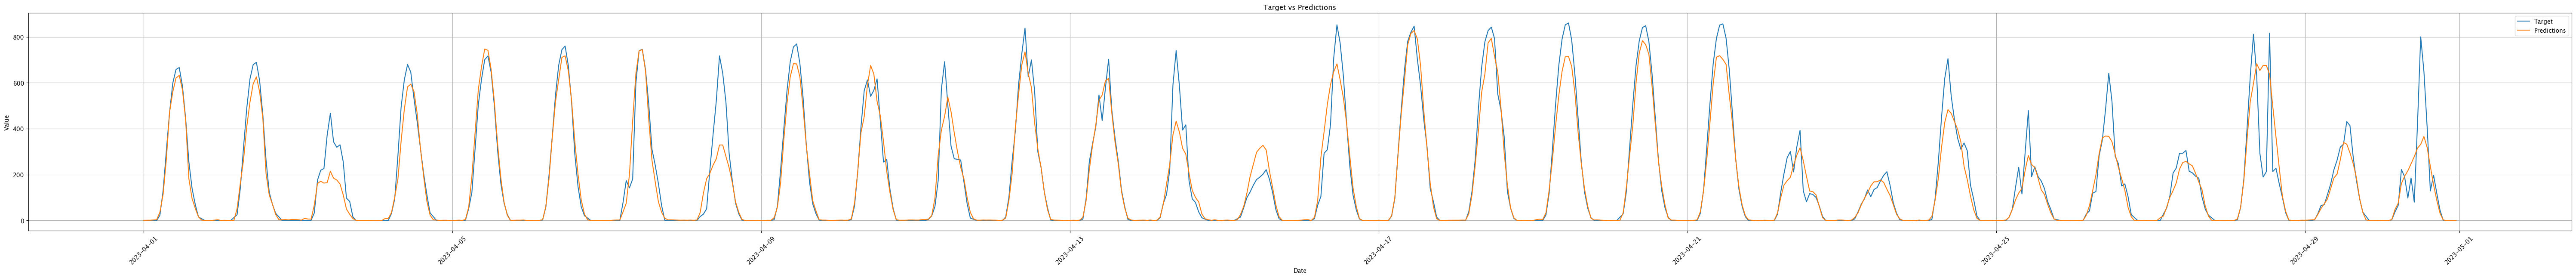

   direct_rad:W  clear_sky_rad:W  diffuse_rad:W  direct_rad_1h:J  \
0           0.0              0.0            0.0              0.0   
1           0.0              0.0            0.0              0.0   
2           0.0              0.0            0.0              0.0   
3           0.0              0.0            0.0              0.0   
4           0.0              0.0            0.0              0.0   

   is_in_shadow:idx  clear_sky_energy_1h:J  diffuse_rad_1h:J  is_day:idx  \
0               1.0                    0.0               0.0         0.0   
1               1.0                    0.0               0.0         0.0   
2               1.0                    0.0               0.0         0.0   
3               1.0                    0.0               0.0         0.0   
4               1.0                    0.0               0.0         0.0   

   sun_elevation:d  ceiling_height_agl:m  ...  snow_melt_10min:mm  \
0       -39.102501           2419.750000  ...                 0.0

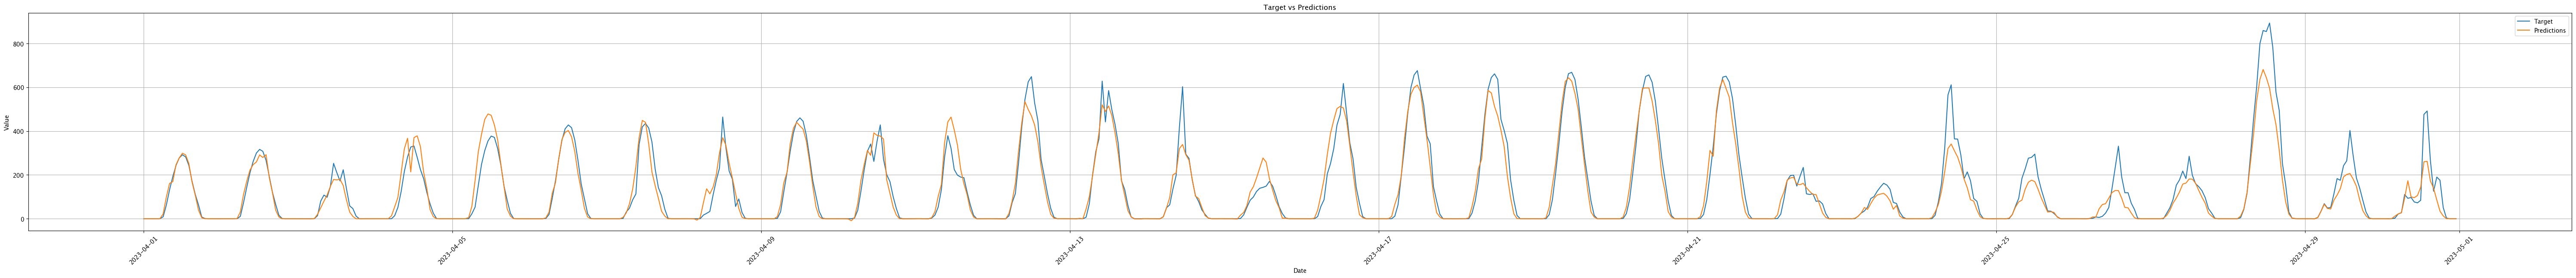

In [73]:
import matplotlib.pyplot as plt

def evaluate_model_locally(location):
    # Load the test data
    data = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    target = pd.read_parquet(f"data/{location}/train_targets.parquet")

    # Make a copy of the date_forecast column
    dates = data["date_forecast"].copy()

    # Create a new DataFrame with dates as the index
    dates_df = pd.DataFrame(index=dates).tail(720*4)
    
    # Resample to 1-hour intervals
    resampled_dates = dates_df.resample('1H').asfreq().index

    # Make predictions
    preds = make_predictions(data, location, target)[-720:]
    # mae = mean_absolute_error(target, preds)
    # print(f"Mean average Error: {mae}")
    target = target.tail(720)["pv_measurement"].to_numpy()
    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(resampled_dates, target, label="Target")
    plt.plot(resampled_dates, preds, label="Predictions")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

for loc in locations:
    evaluate_model_locally(loc)



## Submit to csv

In [74]:
df_submission = pd.read_csv("data/test.csv")

for location in locations: 
    df_test_estimated= pd.read_parquet(f"data/{location}/X_test_estimated.parquet")
    df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    df_test = pd.concat([df_observed, df_estimated, df_test_estimated], axis=0).sort_values(
        by="date_forecast"
    )
    
    preds = make_predictions(df_test, location, df_target)
    
    # Assign the predictions to df_submission for the current location
    mask = df_submission["location"] == location
    print(len(mask))
    # Before this line in your main function

    # Add a check to make sure the lengths match
    if len(preds) != mask.sum():
        print(f"Length of predictions: {len(preds)}")
        print(f"Length of submission entries: {mask.sum()}")
        raise ValueError(f"Mismatch in length of predictions and submission entries for location {location}.")

    df_submission.loc[mask, "prediction"] = preds

# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_3.csv", index=False)

   direct_rad:W  clear_sky_rad:W  diffuse_rad:W  direct_rad_1h:J  \
0          0.00             0.00          0.000         0.000000   
1          0.00             0.00          0.000         0.000000   
2          0.00             0.00          0.000         0.000000   
3          0.00             0.75          0.300         0.000000   
4          0.15            23.10         11.975       282.975006   

   is_in_shadow:idx  clear_sky_energy_1h:J  diffuse_rad_1h:J  is_day:idx  \
0               1.0               0.000000          0.000000        0.00   
1               1.0               0.000000          0.000000        0.00   
2               1.0               0.000000          0.000000        0.00   
3               1.0             208.649994        526.775024        0.25   
4               0.0           32468.150391      22068.949219        1.00   

   sun_elevation:d  ceiling_height_agl:m  ...  snow_melt_10min:mm  \
0         -3.77425           1728.949951  ...                 0.0